# Рынок заведений общественного питания Москвы

## Оглавление
* [Цель проекта](#purpose)
* [Исходные данные](#data)
* [Предобработка данных](#preprocessing)
* [Анализ данных](#analysis)
  * [Соотношение видов объектов общественного питания по количеству](#correct_object_type_pivot)
  * [Соотношение количества сетевых и несетевых объектов общественного питания](#correct_chain_pivot)
  * [Самые распространенные типы объектов питания в сетях и вне сетей](#chain_object_pivot)
  * [Типовое сетевое заведение](#typical)
  * [Средняя вместимость заведений общепита по типам ](#number_pivot)
  * [Определение топ-10 улиц по количеству заведений общепита ](#top_10)
  * [Распределение точек общепита по районам ](#district)
  * [Улицы, на которых расположен один объект питания](#one_object)
  * [Распределение посадочных мест на самых длинных улицах](#long_streets)
* [Выводы](#conclusions)
* [Рекомендации](#recommend)
* [Презентация стартапа](#presentation)



## Цель проекта <a id="purpose"></a>

В этом проекте исследуем насыщенность рынка заведений общественного питания города Москвы, чтобы понять, насколько востребованным будет ресторан с инновационной идеей обслуживания - с официантами-роботами. 

Посмотрим на расположение существующих объектов общепита, проанализируем их вместимость.

По итогам сделаем презентацию для потенциальных инвесторов.

## Исходные данные <a id="data"></a>

In [1]:
#Импорт необходимых библиотек
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from plotly import graph_objects as go
import seaborn as sns
import re
import warnings 
warnings.filterwarnings('ignore')
from io import BytesIO
import requests
!pip3 install --upgrade --user folium
import requests
import json
import time
import zipfile
import io
from bs4 import BeautifulSoup
!pip install geocoder
import geocoder

     |████████████████████████████████| 94 kB 2.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.12.1 which is incompatible.
     |████████████████████████████████| 98 kB 3.4 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
rest_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset_restaurants/rest_data.csv')
display(rest_data.head())
rest_data.info()

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


В нашем распоряжении данные о 15366 объектах общепита Москвы: уникальный идентификатор, название, принадлежность к сети, тип заведения, его адрес и вместимость.

Проверим данные на корректность.

## Предобработка данных <a id="preprocessing"></a>

In [4]:

print('В датасете {} заведений без посадочных мест.'.format(rest_data[rest_data['number'] == 0]['number'].count()))

В датасете 1621 заведений без посадочных мест.


Посмотрим, не ошибка ли это.

In [5]:
rest_data[rest_data['number'] == 0].head()

,id,object_name,chain,object_type,address,number
137,115498,Пекарня & Донер,нет,закусочная,"город Москва, Бутырская улица, дом 9, корпус 2",0
154,152556,Шаурма в пите,нет,предприятие быстрого обслуживания,"город Москва, Варшавское шоссе, дом 72, корпус 2",0
157,149568,Суши,нет,предприятие быстрого обслуживания,"город Москва, улица Маршала Василевского, дом ...",0
190,126956,"Шаурма, куры-гриль",нет,предприятие быстрого обслуживания,"город Москва, 1-я Владимирская улица, дом 21",0
195,149531,"Шаурма, куры-гриль",нет,предприятие быстрого обслуживания,"город Москва, 2-я Владимирская улица, дом 44/10",0


In [6]:
rest_data[rest_data['number'] == 0]['object_type'].unique()
pd.set_option('display.max_colwidth', 1)
rest_data.query('number == 0 and object_type in ("ресторан")').tail()

,id,object_name,chain,object_type,address,number
15084,214843,CoffeeShop,да,ресторан,"город Москва, Кутузовский проспект, дом 57",0
15105,219032,Бургер Кинг,да,ресторан,"город Москва, улица Вавилова, дом 3",0
15108,210192,Бургер Кинг,да,ресторан,"город Москва, поселение Московский, Киевское шоссе, 23-й километр, дом 1, строение 1",0
15236,219130,KFC,да,ресторан,"город Москва, улица Вавилова, дом 3",0
15255,218284,Marmalato,да,ресторан,"город Москва, Хорошёвское шоссе, дом 27",0


Заведения без посадочных мест - это или точки быстрого питания (шаурма, куры-гриль, пекарня), или кафе в торговых центрах (фуд-корты). 

Поскольку это не ошибка, удалять такие строки нет неободимости.


Проверим данные на дубликаты.

In [7]:
print('В таблице {} дублирующихся строк.'.format(rest_data.drop('id', axis = 1).duplicated().sum()))

В таблице 82 дублирующихся строк.


Дубликатов по уникальному идентификатору нет, но есть заведения с одинаковыми характеристиками, находящиеся по одному адресу. Проверим, что это за объекты.

In [8]:
#выводим список дубликатов (вспомогательная строка)
rest_data[rest_data.drop('id', axis = 1).duplicated()]
#берем из списка один адрес для проверки
rest_data.query('address in ("город Москва, Беловежская улица, дом 67", "город Москва, Багратионовский проезд, дом 7, корпус 1")')

,id,object_name,chain,object_type,address,number
4430,23741,СТОЛОВАЯ ГБОУ города Москвы № 384,нет,буфет,"город Москва, Беловежская улица, дом 67",100
4431,23759,СТОЛОВАЯ ГБОУ города Москвы № 384,нет,буфет,"город Москва, Беловежская улица, дом 67",100
5057,20018,LIFT,нет,кафе,"город Москва, Багратионовский проезд, дом 7, корпус 1",25
5058,20019,LIFT,нет,кафе,"город Москва, Багратионовский проезд, дом 7, корпус 1",20
5059,20021,LIFT,нет,кафе,"город Москва, Багратионовский проезд, дом 7, корпус 1",20
5060,20015,LIFT,нет,кафе,"город Москва, Багратионовский проезд, дом 7, корпус 1",40
5068,20024,LIFT,нет,кафе,"город Москва, Багратионовский проезд, дом 7, корпус 1",10
9104,160766,Прайм-кафе,да,кафе,"город Москва, Багратионовский проезд, дом 7, корпус 1",39
12731,192931,Lift,нет,кафе,"город Москва, Багратионовский проезд, дом 7, корпус 1",5
12732,192921,LIFT,нет,кафе,"город Москва, Багратионовский проезд, дом 7, корпус 1",3


Адреса, где дублируются объекты питания - или учебные заведения, или торговые центры. Вполне возможно, что в школах/ВУЗах по несколько одинаковых столовых. И кафе в одном ТЦ может иметь несколько точек, которые открываются, например, в зависимости от сезона (например, летние террасы).
Дубликатов не так много, они не повлияют на исследование. Удалять их не будем.


Обнаружилась другая проблема - одно и то же название встречается в разных регистрах. Возможно, имеет место и разное написание одного и того же сетевого кафе.

Приведем все названия к нижнему регистру.

In [9]:
rest_data['object_name'] = rest_data['object_name'].str.lower()
rest_data.head()

,id,object_name,chain,object_type,address,number
0,151635,сметана,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,кафе «академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,пиццетория,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,кафе «вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


In [10]:
print('Уникальных названий в таблице:', len(rest_data['object_name'].sort_values().unique()))

Уникальных названий в таблице: 9924


In [11]:
#Вывод первых 200 униклаьных названий для поиска дубликатов, закомментирован для экономии места
#rest_data['object_name'].sort_values().unique()[:200]

В уникальных названиях есть много дубликатов с разным написанием, например: 'black star burger', 'black star burger prime', 'black star burgers'. 

Для нашего исследования критичны такие ошибки в написании названий крупных сетевых заведений. Отсортируем объекты по количеству точек в сети и проверим правильность написания.

Уберем из названий все виды кавычек.

In [12]:
rest_data['object_name'] = rest_data['object_name'].str.replace('"', '')
rest_data['object_name'] = rest_data['object_name'].str.replace('«', '')
rest_data['object_name'] = rest_data['object_name'].str.replace('»', '')
rest_data['object_name'] = rest_data['object_name'].str.replace('\'', '')

In [13]:
print('Уникальных названий в таблице после удаления кавычек:', len(rest_data['object_name'].sort_values().unique()))

Уникальных названий в таблице после удаления кавычек: 9836


Самая сложная часть, которую придется выполнить вручную - поиск распространенных различий в написаниях одной и той же сети питания. Отсортируем названия по частоте появления в таблице и осуществим замену.

In [14]:
rest_data.groupby('object_name').agg({'number':'count'}).reset_index().sort_values(by = 'number', ascending = False).head(200)['object_name'].unique()

array(['столовая', 'кафе', 'шаурма', 'шоколадница', 'kfc', 'макдоналдс',
       'бургер кинг', 'теремок', 'доминос пицца', 'крошка картошка',
       'буфет', 'пекарня', 'милти', 'суши wok', 'папа джонс',
       'додо пицца', 'кофе с собой', 'школьно-базовая столовая',
       'чайхона №1', 'донер кебаб', 'кафетерий', 'хинкальная', 'якитория',
       'выпечка', 'кофе хаус', 'subway', 'кофейня', 'тануки',
       'хлеб насущный', 'starbucks', 'прайм стар', 'бистро', 'cofix',
       'иль патио', 'пиццерия', 'му-му', 'мята lounge', 'кулинария',
       'бар', 'старбакс', 'донер', 'сабвей', 'андерсон',
       'кафе хинкальная', 'пицца хат', 'пицца паоло', 'кафе шоколадница',
       'комбинат питания мгту им.н.э.баумана', 'чайхона',
       'кулинарная лавка братьев караваевых', 'кофе', 'вьетнамская кухня',
       'французская пекарня', 'алло пицца', 'кофемания', 'азбука вкуса',
       'сушишоп', 'столовая при гбоу школа 171', 'школа', 'стардогs',
       'чайхана', 'ресторан тануки', 'кружка', '

In [15]:
#создаем словари всех встречающихся названий и меняем на самое распространенное
#проще было бы с регулярными выражениями и шаблонами, но хорошая мысля приходит опосля

burger = ['кафе бургер кинг', 'бургер кинг burger king', 'burgerking', 'ресторан бургер кинг', 'предприятие быстрого обслуживания бургер кинг', 'закусочная бургер кинг', 'кафе-закусочная бургер кинг']
mac = ['ресторан макдоналдс', 'предприятие быстрого обслуживания макдоналдс', 'кафе макдоналдс', 'москва - макдоналдс']
tanuki = ['ресторан тануки', 'кафе тануки']
choko = ['кофейня шоколадница', 'кафе шоколадница', 'шоколадница кофе хаус', 'шоколадница кофемания']
kfc = ['ростикс kfc', 'кафе kfc', 'кфс', 'пбо kfc', 'закусочная kfc', 'kfc волгоградский', 'пбо kfc покрышкина', 'предприятие быстрого обслуживания kfc', 'ресторан kfc']
dunkin = ['dunkin donats', 'dankin donats']
milti = ['точка продажи готовой еды милти', 'милти готовые блюда для здорового питания', 'готовые блюда милти', 'предприятие быстрого обслуживания милти', 'магазин готовой еды милти']
karavai = ['кулинарная лавка братьев караваевых братья караваевы', 'кулинарная лавка братьев караваевых']
dominos = ['пиццерия доминос пицца', 'dominos pizza', "доминос пицца", 'предприятие быстрого обслуживания доминос Пицца', 'ресторан доминос пицца', 'кафе доминос пицца', 'доминос пицца domino,s pizza']
starbucks = ['старбакс starbucks', 'кофейня старбакс', 'кафе сабвей старбакс','старбакс', 'кафе кофейня старбакс', 'кофейня старбакс кофе', 'старбакс кофе', 'starbucks, старбакс кофе', 'старбагс', 'кафе starbucks', 'starbucks кофе', 'starbucks']
ilpatio = ['иль патио планета суши', 'ресторан иль патио', 'кафе иль патио il patio', 'ресторан планета суши иль патио', 'кафе иль патио', 'иль патио', 'planeta sushi il patio', 'il patio']
sushiwok = ['кафе суши вок', 'sushiwok', 'сеть магазинов «суши wok»', 'кафе суши wok', 'кафе сушиwok', 'бар суши wok', 'суши wok']
volk = ['кондитерская волконский', 'волконский', 'волконский у дома', 'кондитерская-пекарня волконский', 'пекарня волконский хлеб', 'кондитерская волконский', 'кафе волконский', 'кафе-пекарея волконский']
rest_data['object_name'] = rest_data['object_name'].replace(volk, 'волконский')
rest_data['object_name'] = rest_data['object_name'].replace(sushiwok, 'суши wok')
rest_data['object_name'] = rest_data['object_name'].replace(ilpatio, 'иль патио')
rest_data['object_name'] = rest_data['object_name'].replace(dominos, 'доминос пицца')
rest_data['object_name'] = rest_data['object_name'].replace(starbucks, 'старбакс')
rest_data['object_name'] = rest_data['object_name'].replace(tanuki, 'тануки')
rest_data['object_name'] = rest_data['object_name'].replace('кафе андерсон', 'андерсон')
rest_data['object_name'] = rest_data['object_name'].replace(kfc, 'kfc')
rest_data['object_name'] = rest_data['object_name'].replace(burger, 'бургер кинг')
rest_data['object_name'] = rest_data['object_name'].replace(choko, 'шоколадница')
rest_data['object_name'] = rest_data['object_name'].replace(dunkin, 'данкин донатс')
rest_data['object_name'] = rest_data['object_name'].replace(karavai, 'братья караваевы')
rest_data['object_name'] = rest_data['object_name'].replace(mac, 'макдоналдс')
rest_data['object_name'] = rest_data['object_name'].replace('дабл би', 'даблби')
rest_data['object_name'] = rest_data['object_name'].replace('стардогs', 'стардогс')
rest_data['object_name'] = rest_data['object_name'].replace('кафе хинкальная', 'хинкальная')
rest_data['object_name'] = rest_data['object_name'].replace('кафе штолле', 'штолле')
rest_data['object_name'] = rest_data['object_name'].replace('кафе теремок', 'теремок')
rest_data['object_name'] = rest_data['object_name'].replace(milti, 'милти')

In [16]:
print('Уникальных названий в таблице после приведения в соответствие названий:', len(rest_data['object_name'].sort_values().unique()))

Уникальных названий в таблице после приведения в соответствие названий: 9763


In [17]:
print('Число уникальных названий в таблице сократилось на', 9924 - len(rest_data['object_name'].sort_values().unique()))

Число уникальных названий в таблице сократилось на 161


Итак, после обработки количество уникальных названий сократилось более чем на 100. 

Проверка показала, что одно и то же заведение в таблице может относиться к разному типу. Создадим столбец, в котором каждому названию заведения будет соответствовать самый часто встречающийся тип.

In [18]:
#Создаем сводную таблицу с сортировкой по частоте упоминания названий в таблице
object_type_pivot = rest_data.pivot_table(index = ['object_name','object_type'], values = 'number', aggfunc = 'count').sort_values(by = 'number', ascending = False).reset_index()
#Создаем список названий и наиболее часто упоминающихся типов заведений
object_types_list = object_type_pivot.groupby('object_name').agg({'object_type':'first'}).reset_index()
object_types_list.columns = ['object_name', 'correct_object_type']
object_types_list.head()

,object_name,correct_object_type
0,1-й мок,столовая
1,1-ый московский кадетский корпус,столовая
2,100 личная столовая,столовая
3,100 личное кафе,кафе
4,1001 ночь,ресторан


In [19]:
rest_data = rest_data.merge(object_types_list, on = 'object_name', how = 'left')
rest_data.head()

,id,object_name,chain,object_type,address,number,correct_object_type
0,151635,сметана,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,кафе
1,77874,родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,кафе
2,24309,кафе академия,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,кафе
3,21894,пиццетория,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,кафе
4,119365,кафе вишневая метель,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,кафе


In [20]:
#Проверяем, что даже самым встречающимся названиям соответствует только один тип заведения
check = (rest_data.pivot_table(index = 'object_name', 
                               values = ['object_type','correct_object_type'], 
                               aggfunc = {'object_type':'count', 'correct_object_type':'nunique'}).
         reset_index().
         sort_values(by = 'object_type', ascending = False)
)
check.head()

,object_name,correct_object_type,object_type
7492,столовая,1,321
3437,кафе,1,278
9305,шаурма,1,250
9639,шоколадница,1,188
619,kfc,1,187


In [21]:
#Удаляем столбец с неверными типами заведений
rest_data = rest_data.drop('object_type', axis = 1)
#rest_data.head()

Проверим, все ли сетевые заведения (название встречается в таблице несколько раз) отнесены к таковым в столбце `chain`.

In [22]:
check_chain = (rest_data.pivot_table(index = 'object_name', 
                               values = ['number','chain'], 
                               aggfunc = {'number':'count', 'chain':'nunique'}).
         reset_index().
         sort_values(by = 'number', ascending = False)
)
check_chain.head(10)

,object_name,chain,number
7492,столовая,1,321
3437,кафе,1,278
9305,шаурма,1,250
9639,шоколадница,2,188
619,kfc,2,187
5328,макдоналдс,1,172
1932,бургер кинг,2,162
2955,доминос пицца,2,107
8641,теремок,2,105
5043,крошка картошка,1,90


Есть ошибки и в этом столбце. Создадим столбец с верными значениями `correct_chain` аналогично столбцу `correct_object_type`.

In [23]:
#Создаем сводную таблицу с сортировкой по частоте упоминания названий в таблице
chain_pivot = rest_data.pivot_table(index = ['object_name','chain'], values = 'number', aggfunc = 'count').sort_values(by = 'number', ascending = False).reset_index()
#Создаем список названий и наиболее распространенного значения в столбце chain
chain_list = chain_pivot.groupby('object_name').agg({'chain':'first'}).reset_index()
chain_list.columns = ['object_name', 'correct_chain']
rest_data = rest_data.merge(chain_list, on = 'object_name', how = 'left')
check_chain = (rest_data.pivot_table(index = 'object_name', 
                               values = ['number','correct_chain'], 
                               aggfunc = {'number':'count', 'correct_chain':'nunique'}).
         reset_index().
         sort_values(by = 'number', ascending = False)
)
check_chain.head(10)

,object_name,correct_chain,number
7492,столовая,1,321
3437,кафе,1,278
9305,шаурма,1,250
9639,шоколадница,1,188
619,kfc,1,187
5328,макдоналдс,1,172
1932,бургер кинг,1,162
2955,доминос пицца,1,107
8641,теремок,1,105
5043,крошка картошка,1,90


In [24]:
#Удаляем столбец с неверной принадлежностью к сети
rest_data = rest_data.drop('chain', axis = 1)
rest_data.head()

,id,object_name,address,number,correct_object_type,correct_chain
0,151635,сметана,"город Москва, улица Егора Абакумова, дом 9",48,кафе,нет
1,77874,родник,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,кафе,нет
2,24309,кафе академия,"город Москва, Абельмановская улица, дом 6",95,кафе,нет
3,21894,пиццетория,"город Москва, Абрамцевская улица, дом 1",40,кафе,да
4,119365,кафе вишневая метель,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,кафе,нет


Проверим, есть ли строки, в которых к сетевым отнесены заведения, имеющие только одну точку.

In [25]:
check_chain_pivot = rest_data.query('correct_chain == "да"').pivot_table(index = 'object_name', values = 'id', aggfunc = 'count').reset_index().sort_values(by = 'id')
print('В таблице {} строк, в которых несетевые заведения отнесены к сетям.'.format(len(check_chain_pivot.query('id == 1'))))

В таблице 263 строк, в которых несетевые заведения отнесены к сетям.


Исправим эти строки.

In [26]:
correct_chain_2_list = list(check_chain_pivot.query('id == 1')['object_name'])
rest_data.loc[(rest_data.object_name.isin(correct_chain_2_list)), 'correct_chain'] = 'нет'

check_chain_pivot2 = rest_data.query('correct_chain == "да"').pivot_table(index = 'object_name', values = 'id', aggfunc = 'count').reset_index().sort_values(by = 'id')
print('В таблице {} строк, в которых несетевые заведения отнесены к сетям.'.format(len(check_chain_pivot2.query('id == 1'))))

В таблице 0 строк, в которых несетевые заведения отнесены к сетям.


Итак, в ходе предобработки данных было сделано следующее:
* Названия приведены к нижнему регистру;
* Убраны все кавычки из названий;
* Для крупных сетевых заведений названия приведены к одному на сеть с помощью словарей синонимов;
* Создан столбец с верной привязкой типа заведения к его названию;
* Создан столбец с верной привязкой принадлежности к сети;
* Для заведений, встречающихся один раз, тип принадлежности к сети установлен как "несетевое".

Можно приступать к анализу.

## Анализ данных <a id="analysis"></a>

### Соотношение видов объектов общественного питания по количеству <a id="correct_object_type_pivot"></a>

Построим два графика, показывающих доминирующие типы заведений питания в Москве.

In [27]:
#Строим сводную таблицу тип заведения - количество объектов
correct_object_type_pivot = rest_data.pivot_table(index = 'correct_object_type', values = 'number', aggfunc = 'count').reset_index()

In [28]:
#Список объектов в порядке возрастания (для того, чтобы расставить переносы в подписях)
#list(correct_object_type_pivot.sort_values(by = 'number', ascending = True)['correct_object_type'])
data = correct_object_type_pivot.sort_values(by = 'number', ascending = True)

fig = px.bar(
    data, x='number', y='correct_object_type', title='Диаграмма соотношения типов заведений питания по количеству',
    orientation='h'
)
fig.update_yaxes(title='Тип заведения', side = 'left', showgrid = True)
fig.update_xaxes(title='Количество заведений в Москве', showgrid = True)
fig.show()


In [29]:

fig = go.Figure(data=[go.Pie(labels=correct_object_type_pivot['correct_object_type'], values=correct_object_type_pivot['number'])])
fig.update_layout(title_text="Доли типов заведений общественного питания Москвы",
                  title_font_size=18)
fig.show()


Среди заведений общепита лидируют кафе - более 6000 точек в Москве, больше 40% от общего количества.

На втором месте - почти 17% - столовые (включая объекты в школах и ВУЗах), на третьем - почти 15% - предприятия быстрого обслуживания.

Московские рестораны (2000 точек) занимают четвертое место с долей около 14%.

### Соотношение количества сетевых и несетевых объектов общественного питания <a id="correct_chain_pivot"></a>

Сравним, сколько в Москве сетевых и оригинальных заведений.

In [30]:
#Строим сводную таблицу тип заведения - количество объектов
correct_chain_pivot = rest_data.pivot_table(index = 'correct_chain', values = 'number', aggfunc = 'count').reset_index()
correct_chain_pivot

,correct_chain,number
0,да,2752
1,нет,12614


In [31]:
data = correct_chain_pivot.sort_values(by = 'number', ascending = True)
fig = px.bar(
    data, x='number', y='correct_chain', title='Соотношение количества сетевых/несетевых заведений в Москве',
    orientation='h'
)
fig.update_yaxes(title='Сетевое (да/нет)', side = 'left', showgrid = True)
fig.update_xaxes(title='Количество заведений', showgrid = True)
fig.show()

In [32]:
fig = go.Figure(data=[go.Pie(labels=correct_chain_pivot['correct_chain'], values=correct_chain_pivot['number'])])
fig.update_layout(title_text="Доли сетевых и несетевых заведений общественного питания Москвы",
                  title_font_size=18)
fig.show()

Итак, на сетевые предприятия приходится меньше 20% рынка объектов общепита. 

Конкуренция на рынке уникальных заведений высока - таких объектов в Москве около 12,5 тысяч.

### Самые распространенные типы объектов питания в сетях и вне сетей <a id="chain_object_pivot"></a>

Выясним, для какого типа заведения общепита более характерно сетевое распространение.

In [33]:
type_chain_char = rest_data.pivot_table(index = 'correct_object_type', columns = 'correct_chain', values = 'id', aggfunc = 'count').fillna(0).reset_index()
type_chain_char.columns = ['object_type', 'chain_number', 'not_chain_number']
type_chain_char['%_chain'] = type_chain_char['chain_number'] / (type_chain_char['chain_number'] + type_chain_char['not_chain_number'])
type_chain_char['%_not_chain'] = type_chain_char['not_chain_number'] / (type_chain_char['chain_number'] + type_chain_char['not_chain_number'])
type_chain_char.sort_values(by = '%_chain', ascending = False).style.format({'%_chain': '{:.2%}', '%_not_chain': '{:.2%}'})

,object_type,chain_number,not_chain_number,%_chain,%_not_chain
6,предприятие быстрого обслуживания,1005.000000,1255.000000,44.47%,55.53%
3,кафе,1344.000000,4951.000000,21.35%,78.65%
7,ресторан,372.000000,1732.000000,17.68%,82.32%
2,закусочная,4.000000,180.000000,2.17%,97.83%
0,бар,17.000000,833.000000,2.00%,98.00%
4,кафетерий,5.000000,317.000000,1.55%,98.45%
5,магазин (отдел кулинарии),3.000000,194.000000,1.52%,98.48%
1,буфет,2.000000,570.000000,0.35%,99.65%
8,столовая,0.000000,2582.000000,0.00%,100.00%


Итак, если рассматривать доли сетевых заведений, лидировать будут предприятия быстрого обслуживания. Почти половина таких объектов принадлежит сетям.

На втором месте кафе (23%), на третьем - рестораны (21%).

Сетевых столовых, оказывается, не бывает. :)

In [34]:
cafe = ['предприятие быстрого обслуживания', 'кафе', 'ресторан']
for i in cafe:
  popular_chain_cafe = rest_data.query('correct_chain == "да"').query('correct_object_type == @i').groupby('object_name').agg({'number':'count'}).sort_values(by = 'number', ascending = False)
  print('Топ-5 сетей', i)
  display(popular_chain_cafe.head())

Топ-5 сетей предприятие быстрого обслуживания


,number
object_name,
kfc,187
макдоналдс,172
бургер кинг,162
теремок,105
крошка картошка,90


Топ-5 сетей кафе


,number
object_name,
шоколадница,188
доминос пицца,107
суши wok,78
старбакс,65
хинкальная,56


Топ-5 сетей ресторан


,number
object_name,
тануки,47
иль патио,46
чайхона №1,43
якитория,38
корчма тарас бульба,10


Сетевые предприятия быстрого обслуживания и кафе преобладают в Москве.Такой стиль питания характерен для торопливого столичного образа жизни. 

По этой же причине среди несетевых заведений тоже лидируют кафе - средний ценник, быстрая подача, простые блюда.

Лидеры сетевых кафе - Шоколадница и пиццерия Доминос. Среди заведений "быстрого" общепита - вечные соперники KFC, Макдоналдс и Бургер Кинг.

### Типовое сетевое заведение <a id="typical"></a>

Опишем типовое московское заведение.

In [35]:
#Выводим минимальное, максимальное, среднее и медианное значения по всем заведениям Москвы
rest_data.query('number != 0')['number'].describe()

count    13745.000000
mean     66.569807   
std      76.005550   
min      1.000000    
25%      20.000000   
50%      44.000000   
75%      85.000000   
max      1700.000000 
Name: number, dtype: float64

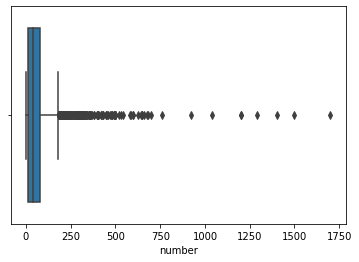

In [36]:
#Строим диаграмму размаха, чтобы увидеть количество выбросов
sns.boxplot(data = rest_data, x = 'number')
plt.show()

In [37]:
print(np.percentile(rest_data['number'], [90, 95, 99]))

[150. 214. 300.]


Среди всех объектов общепита Москвы, имеющих столики, медианное значение количества посадочных мест - 44 (медиану берем из-за наличия аномальных значений, которые видны на диаграмме размаха).

99% московских заведений имеют не больше 300 посадочных мест.




Для корректного анализа уберем выбросы по количеству посадочных мест из таблицы.

In [38]:
rest_data = rest_data.query('number <= 300')
#Проверка
#rest_data.query('number != 0')['number'].describe()

In [39]:
#Фильтруем данные по сетям
chain_number = rest_data.query('correct_chain == "да"').groupby('object_name').agg({'address':'count', 'number':'mean'}).sort_values(by = 'address', ascending = False)
chain_number.columns = ['number_of_objects', 'mean_capacity']
chain_number.head(10)

,number_of_objects,mean_capacity
object_name,,
шоколадница,188,57.547872
kfc,186,54.231183
макдоналдс,170,81.752941
бургер кинг,162,48.024691
доминос пицца,107,17.738318
теремок,105,26.828571
крошка картошка,90,21.855556
милти,83,1.168675
суши wok,78,6.820513


По таблице видно, что сетевые "монстры" (Шоколадница, KFC, Макдоналдс) предпочитают большой охват со средней вместимостью.

Предприятия поменьше открывают больше точек с меньшим количеством посадочных мест (Доминос, Теремок, Крошка-Картошка и т.д.).

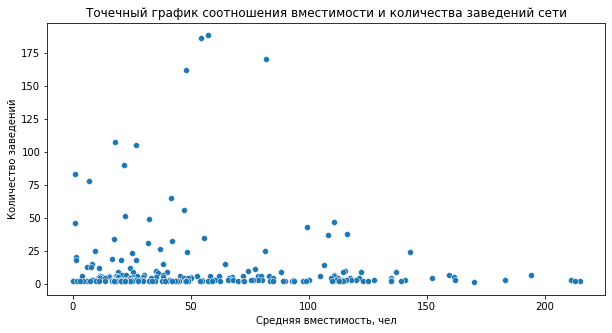

In [40]:
plt.figure(figsize=(10,5))
plt.title('Точечный график соотношения вместимости и количества заведений сети')
sns.scatterplot(data = chain_number, y = 'number_of_objects', x = 'mean_capacity')
plt.xlabel('Средняя вместимость, чел')
plt.ylabel('Количество заведений')
plt.show()

Точечный график подтверждает тенденцию: для сетевых заведений характерна небольшая вместимость с большим количеством объектов.

Большое количество точек в районе 0 по оси Y связано с ошибками написания названий в небольших сетях, которые мы оставили, т.к. они не будут сильно влиять на расчёты.

### Средняя вместимость заведений общепита по типам <a id="number_pivot"></a>

In [41]:
print('Средняя вместимость заведения в зависимости от типа')
number_pivot = rest_data.pivot_table(index = 'correct_object_type', values = 'number', aggfunc = 'mean').sort_values(by = 'number', ascending = False).reset_index()
number_pivot

Средняя вместимость заведения в зависимости от типа


,correct_object_type,number
0,столовая,124.325444
1,ресторан,88.376165
2,буфет,53.744308
3,бар,42.358068
4,кафе,38.428208
5,предприятие быстрого обслуживания,21.196278
6,кафетерий,10.229814
7,закусочная,7.489130
8,магазин (отдел кулинарии),5.543147


In [42]:
data = number_pivot.sort_values(by = 'number', ascending = True)
fig = px.bar(
    data, x='number', y='correct_object_type', title='Диаграмма соотношения типов заведений по средней вместимости',
    orientation='h'
)
fig.update_yaxes(title='Тип заведения', side = 'left', showgrid = True)
fig.update_xaxes(title='Вместимость, человек', showgrid = True)
fig.show()

Среди всех объектов питания больше всего мест в столовых, включая школьные и вузовские (в среднем 124). На втором месте рестораны со средней вместимостью 88 мест.

Разная вместимость обусловлена спецификой заведений общепита.

Столовые гарантированно ежедневно обслуживают огромное количество учащихся за ограниченное время, поэтому имеют макисмальное количество мест.

Пиковое время посещения ресторанов - несколько часов в день. Некоторые из них в связи с этим даже имеют смещенный график работы. Для окупаемости им необходимо иметь довольно большую вместимость.

### Определение топ-10 улиц по количеству заведений общепита <a id="top_10"></a>

Для анализа самых популярных в гастрономическом смысле улиц сформируем отдельный столбец, в который выделим их название из столбца с адресом.

In [43]:
#Создаем словарь, в котором перечислим основные категории городских дорог, встречающихся в файле
words = ['улица','ул','переулок','шоссе','проспект','площадь','проезд',
         'село','аллея','бульвар','набережная','тупик','линия', 'просек', 'луч', 'спуск', 'ряд', 'вал', 'деревня', 'микрорайон', 'посёлок', 'Зеленоград', 'поселение', 'автодороги', 'квартал', 'территория']
#В регулярном выражении отсекаем часть адреса до запятой (город), затем выбираем все слова, которые без запятой соседствуют со словами из списка выше, дальше отсекаем все после следующей запятой
str_pat = r".*,\s*\b([^,]*?(?:{})\b[^,]*)[,$]+".format("|".join(words))
#создаем новый столбец, куда пишутся названия улицы (регистр игнорируется)
rest_data['street'] = rest_data['address'].str.extract(str_pat, flags=re.I)
#Те строки, которые не начинались с названия города, остались необработанными. Заменяем отсутствующие значения на 0 для удобства работы
rest_data['street'] = rest_data['street'].fillna(0)
#Регулярка для отсечения названия улицы в этих строках (до первой запятой)
str_pat1 = r"(^.*?,)"
#вспомогательный столбец для выделения улицы в оставшихся строках
rest_data['street2'] = rest_data.query('street == 0')['address'].str.extract(str_pat1, flags=re.I)
#Убираем лишню запятую
rest_data['street2'] = rest_data['street2'].replace(',','', regex = True)
#Заменяем нули в основном столбце значениями из вспомогательного
rest_data['street'] = np.where(rest_data['street'] == 0, rest_data['street2'], rest_data['street'])
#Проверка
#rest_data.query('street == "Шарикоподшипниковская улица"')

In [44]:
#Удаляем вспомогательный столбец
rest_data = rest_data.drop('street2', axis=1)
rest_data.head()

,id,object_name,address,number,correct_object_type,correct_chain,street
0,151635,сметана,"город Москва, улица Егора Абакумова, дом 9",48,кафе,нет,улица Егора Абакумова
1,77874,родник,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,кафе,нет,улица Талалихина
2,24309,кафе академия,"город Москва, Абельмановская улица, дом 6",95,кафе,нет,Абельмановская улица
3,21894,пиццетория,"город Москва, Абрамцевская улица, дом 1",40,кафе,да,Абрамцевская улица
4,119365,кафе вишневая метель,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,кафе,нет,Абрамцевская улица


После того, как мы получили отдельный столбец с названием улицы, строим сводную таблицу, чтобы узнать, на каких улицах расположено больше всего заведений питания.

In [45]:
#Исключаем округ Зеленоград, т.к. в городе нет деления на улицы, и статистика по нему не будет корректной
street_pivot = rest_data.query('street != "город Зеленоград"').pivot_table(index = 'street', values = 'id', aggfunc = 'count').reset_index()
street_pivot.columns = ['street', 'objects_number']
street_pivot.sort_values(by = 'objects_number', ascending = False).head(10)


,street,objects_number
1497,проспект Мира,203
1040,Профсоюзная улица,183
711,Ленинградский проспект,172
1023,Пресненская набережная,165
424,Варшавское шоссе,163
714,Ленинский проспект,147
1493,проспект Вернадского,130
701,Кутузовский проспект,112
624,Каширское шоссе,110
631,Кировоградская улица,110


Результат ожидаемый - больше всего заведений расположено на радиальных длинных улицах Москвы. Исключение - Пресненская набережная, на которой находится Москва-Сити с огромным количеством заведений.

Посмотрим, через какие районы проходят эти улицы.

Для этого обратимся к сервису геокодинга HERE, который дает 250 000 бесплатных обращений в месяц и позволяет запрашивать пакетную обработку адресов.

In [46]:
#Подготовка входных данных для обработки. Два столбца с определенными названиями:
address_table = rest_data['address'].reset_index()
address_table.columns = ['recId', 'searchText']
address_table.head()
address_table.to_csv('address_table_b.csv', sep = ';')

In [47]:
#Скрипт, отдающий подготовленный файл в геокодер и получающий от него результат



#Создаем класс, в который свернуты нужные функции 
class Batch:
#Авторизация на сервисе
    SERVICE_URL = "https://batch.geocoder.ls.hereapi.com/6.2/jobs"
    jobId = None

    def __init__(self, apikey="MY_REST_API"):
        self.apikey = apikey
        
#Загрузка файла            
    def start(self, filename, indelim=";", outdelim=";"):
        
        file = open(filename, 'rb')

        params = {
            "action": "run",
            "apiKey": self.apikey,
            "politicalview":"RUS",
            "gen": 9,
            "maxresults": "1",
            "header": "true",
            "indelim": indelim,
            "outdelim": outdelim,
            "outcols": "displayLatitude,displayLongitude,locationLabel,houseNumber,street,district,city,postalCode,county,state,country",
            "outputcombined": "true",
        }

        response = requests.post(self.SERVICE_URL, params=params, data=file)
        self.__stats (response)
        file.close()
    
#Проверка статуса запроса
    def status (self, jobId = None):

        if jobId is not None:
            self.jobId = jobId
        
        statusUrl = self.SERVICE_URL + "/" + self.jobId
        
        params = {
            "action": "status",
            "apiKey": self.apikey,
        }
        
        response = requests.get(statusUrl, params=params)
        self.__stats (response)
        
#запрос результата
    def result (self, jobId = None):

        if jobId is not None:
            self.jobId = jobId
        
        print("Requesting result data ...")
        
        resultUrl = self.SERVICE_URL + "/" + self.jobId + "/result"
        
        params = {
            "apiKey": self.apikey
        }
        
        response = requests.get(resultUrl, params=params, stream=True)
        
        if (response.ok):    
            zipResult = zipfile.ZipFile(io.BytesIO(response.content))
            zipResult.extractall()
            print("File saved successfully")
        
        else:
            print("Error")
            print(response.text)
    

#вывод результата    
    def __stats (self, response):
        if (response.ok):
            parsedXMLResponse = BeautifulSoup(response.text, "lxml")

            self.jobId = parsedXMLResponse.find('requestid').get_text()
            
            for stat in parsedXMLResponse.find('response').findChildren():
                if(len(stat.findChildren()) == 0):
                    print("{name}: {data}".format(name=stat.name, data=stat.get_text()))

        else:
            print(response.text)



In [48]:
#Запуск в работу скрипта, скрипт отработал, все закомментировала
#from geocoder import Batch
#service = Batch(apikey="MY_REST_API")
#service.start("/content/address_table_b2.csv", indelim=";", outdelim=";")

In [49]:
#service.status()

In [50]:
#service.result()

In [51]:
#Открываем полученный файл, загруженный на Google Drive

spreadsheet_id = '1fcsVY2ezeZ26Nb-bTy68iHD7f1A6A1xf26SyUVUTBU8'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
df = pd.read_csv(BytesIO(r.content))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15243 entries, 0 to 15242
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   recId             15243 non-null  int64  
 1   searchText        15243 non-null  object 
 2   displayLatitude   15010 non-null  float64
 3   displayLongitude  15010 non-null  float64
 4   locationLabel     15010 non-null  object 
 5   houseNumber       14836 non-null  object 
 6   street            14991 non-null  object 
 7   district          14994 non-null  object 
 8   city              15010 non-null  object 
 9   postalCode        15002 non-null  float64
 10  county            15010 non-null  object 
dtypes: float64(3), int64(1), object(7)
memory usage: 1.3+ MB


Получен файл, содержащий координаты, столбцы с улицей и районом.

Эти данные более точны, чем полученные выше при обработке вручную, далее будем использовать их. 

Объединяем полученную таблицу с основной по индексу.

In [52]:
rest_data = rest_data.reset_index()


In [53]:
rest_data = rest_data.merge(df, left_on = 'index', right_on = 'recId', how = 'left')


In [54]:
#Наводим красоту, убирая лишние столбцы и присваивая короткие названия
rest_data = rest_data.drop(columns = ['street_x', 'recId', 'searchText'])
rest_data = rest_data.rename(columns = {'street_y':'street'})
rest_data.tail()

,index,id,object_name,address,number,correct_object_type,correct_chain,displayLatitude,displayLongitude,locationLabel,houseNumber,street,district,city,postalCode,county
15238,15361,208537,шоколадница,"город Москва, 3-й Крутицкий переулок, дом 18",50,кафе,да,55.73177,37.66402,"3-й Крутицкий переулок 18, Москва, Россия, 109044",18,3-й Крутицкий переулок,Таганский,Москва,109044.0,Москва
15239,15362,209264,шоколадница,"город Москва, улица Земляной Вал, дом 33",10,кафе,да,55.75721,37.65909,"улица Земляной вал 33, Москва, Россия, 105064",33,улица Земляной вал,Басманный,Москва,105064.0,Москва
15240,15363,209186,шоколадница,"город Москва, улица Земляной Вал, дом 33",20,кафе,да,55.75721,37.65909,"улица Земляной вал 33, Москва, Россия, 105064",33,улица Земляной вал,Басманный,Москва,105064.0,Москва
15241,15364,221900,шоколадница,"город Москва, поселение Московский, Киевское шоссе, 22-й километр, домовладение 4, строение 1",36,кафе,да,55.47220,36.93128,"Киевское шоссе 6, Москва, Россия, 143340",6,Киевское шоссе,Рассудово посёлок,Москва,143340.0,Москва
15242,15365,222535,шоколадница,"город Москва, Ходынский бульвар, дом 4",10,кафе,да,55.79016,37.53130,"Ходынский бульвар 4, Москва, Россия, 125252",4,Ходынский бульвар,Хорошёвский,Москва,125252.0,Москва


Строим обновленную таблицу топ-10 улиц по количеству объектов общепита.

In [55]:
street_pivot = rest_data.query('street != "Зеленоград"').pivot_table(index = 'street', values = 'id', aggfunc = 'count').reset_index().sort_values(by = 'id', ascending = False)

street_top_10 = street_pivot.head(10)
street_top_10.columns = ['street', 'objects_number']
street_top_10


,street,objects_number
1432,проспект Мира,203
1023,Профсоюзная улица,183
697,Ленинградский проспект,172
1007,Пресненская набережная,165
404,Варшавское шоссе,162
700,Ленинский проспект,146
1428,проспект Вернадского,130
687,Кутузовский проспект,112
609,Каширское шоссе,110
616,Кировоградская улица,110


Данные совпадают с полученными ранее, однако этот вариант позволит нам автоматически получить район в зависимости от адреса и нанести на карту точки для визуализации результата.

### Распределение точек общепита по районам <a id="district"></a>

In [56]:
#Создаем список топ-10 самых насыщенных общепитом улиц
street_top_10_list = list(street_top_10['street'])
street_top_10_list

['проспект Мира',
 'Профсоюзная улица',
 'Ленинградский проспект',
 'Пресненская набережная',
 'Варшавское шоссе',
 'Ленинский проспект',
 'проспект Вернадского',
 'Кутузовский проспект',
 'Каширское шоссе',
 'Кировоградская улица']

In [57]:
#Формируем сводную таблицу связи улицы и района
street_district = rest_data.query('street in @street_top_10_list').pivot_table(index = ['street', 'district'], values = 'id', aggfunc = 'nunique')
display(street_district)

id
street                 district                      
Варшавское шоссе       Бутово Южное               2  
                       Донской                    36 
                       Нагатино-Садовники         7  
                       Нагорный                   44 
                       Чертаново Северное         23 
                       Чертаново Центральное      12 
                       Чертаново Южное            38 
Каширское шоссе        Москворечье-Сабурово       46 
                       Нагатино-Садовники         48 
                       Орехово-Борисово Северное  10 
                       Орехово-Борисово Южное     6  
Кировоградская улица   Чертаново Северное         21 
                       Чертаново Центральное      79 
                       Чертаново Южное            10 
Кутузовский проспект   Дорогомилово               59 
                       Фили-Давыдково             53 
Ленинградский проспект Аэропорт                   65 
                       Беговой                    66 
                       Сокол                      24 
                       Хорошёвский                17 
Ленинский проспект     Гагаринский                39 
                       Донской                    15 
                       Ломоносовский              12 
                       Обручевский                31 
                       Проспект Вернадского       2  
                       Тропарёво-Никулино         19 
                       Тёплый Стан                4  
                       Якиманка                   24 
Пресненская набережная Пресненский                165
Профсоюзная улица      Академический              25 
                       Коньково                   35 
                       Обручевский                28 
                       Тёплый Стан                40 
                       Черёмушки                  41 
                       Ясенево                    14 
проспект Вернадского   Гагаринский                1  
                       Ломоносовский              14 
                       Проспект Вернадского       14 
                       Раменки                    32 
                       Тропарёво-Никулино         69 
проспект Мира          Алексеевский               43 
                       Мещанский                  63 
                       Останкинский               27 
                       Ростокино                  7  
                       Свиблово                   62 
                       Ярославский                1

В виде таблицы информация не очень читаема. Можно только сказать, что больше всего заведений из выборки топ-10 улиц в Пресненском районе (Москва-Сити!), а также в Центральном Чертанове и Тропарёве-Никулине. Большие районы, логично, что в них попадает большое количество заведений.

Визуализируем это распределение на карте.

In [58]:
import folium
from folium.plugins import MarkerCluster
lat = rest_data.query('street in @street_top_10_list')['displayLatitude']
lon = rest_data.query('street in @street_top_10_list')['displayLongitude']
district = rest_data.query('street in @street_top_10_list')['district']
map = folium.Map(location=[55.7522,37.6156], zoom_start = 5)
marker_cluster = MarkerCluster().add_to(map)
for lat, lon, district in zip(lat, lon, district):
    folium.CircleMarker(location=[lat, lon], radius = 9, popup=str(district)+" m", color="gray", fill_opacity = 0.9).add_to(marker_cluster)
map.save("map1.html")


In [59]:
from ipywidgets import Image
#https://drive.google.com/file/d/1O0CNGPJ0jR3qBrxbV-kbIaUQzaCQ7cd9/view?usp=sharing
Image(value=requests.get('http://drive.google.com/uc?export=view&id=1O0CNGPJ0jR3qBrxbV-kbIaUQzaCQ7cd9').content)

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00\x90\x00\x90\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

На карте видно, что заведения из топ-10 улиц тяготеют к радильным магистралям. Эти улицы длинные, поэтому большое количество кафе на них не говорит ни о чем конкретном.

Сравним, как изменится картинка, если нанести на карту все заведения по районам.

In [60]:
district_pivot = rest_data.pivot_table(index = 'district', values = 'id', aggfunc = 'count')
district_pivot.columns = ['objects_number']
display(district_pivot.sort_values(by = 'objects_number', ascending = False).head(10))

,objects_number
district,
Тверской,771
Пресненский,712
Басманный,622
Даниловский,454
Замоскворечье,383
Хамовники,365
Таганский,357
Мещанский,351
Арбат,265


Результат логичен - в центральных районах наиболее густое скопление всевозможных кафе, ресторанов и столовых.

Посмотрим на карту.


In [61]:
rest_data = rest_data.dropna()
lat = rest_data['displayLatitude']
lon = rest_data['displayLongitude']
district = rest_data['district']
map = folium.Map(location=[55.7522,37.6156], zoom_start = 5)
marker_cluster = MarkerCluster().add_to(map)
for lat, lon, district in zip(lat, lon, district):
    folium.CircleMarker(location=[lat, lon], radius = 9, popup=str(district)+" m", color="gray", fill_opacity = 0.9).add_to(marker_cluster)
map.save("map2.html")

In [62]:
#https://drive.google.com/file/d/1TfRx2vNQAgnUvRECbRJNqSyJHwfnxiNc/view?usp=sharing
print('Районное распределение заведений общепита в Москве')
Image(value=requests.get('http://drive.google.com/uc?export=view&id=1TfRx2vNQAgnUvRECbRJNqSyJHwfnxiNc').content)

Районное распределение заведений общепита в Москве


Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00\x90\x00\x90\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

In [63]:
#https://drive.google.com/file/d/1HSeHbQt-gGOd5CtgTC9kF1Lb4GUT9y0y/view?usp=sharing
print('Распределение заведений общепита в центре Москвы')
Image(value=requests.get('http://drive.google.com/uc?export=view&id=1HSeHbQt-gGOd5CtgTC9kF1Lb4GUT9y0y').content)

Распределение заведений общепита в центре Москвы


Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00\x90\x00\x90\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

Самая жесткая конкуренция ждет владельцев бизнеса в районе Арбата, Тверской, Замоскворечья. Одним словом, в историческом центре. 

Центр - туристическое место, большое количество заведений именно в ЦАО обусловлено ориентацией на гостей столицы.

Рассчитаем максимальное количество заведений на улицах центральных районов.

In [64]:
district_dict = ['Тверской', 'Пресненский', 'Даниловский',	'Замоскворечье', 'Хамовники']
for i in district_dict:
  print('Район', i)
  number_for_street = rest_data.query('district in @i').pivot_table(index = 'street', values = 'id', aggfunc = 'count').reset_index().sort_values(by = 'id', ascending = False).head(3)
  display(number_for_street)

Район Тверской


,street,id
66,Тверская улица,65
36,Лесная улица,61
77,улица Большая Дмитровка,51


Район Пресненский


,street,id
52,Пресненская набережная,165
35,Краснопресненская набережная,39
10,Большая Никитская улица,38


Район Даниловский


,street,id
37,улица Ленинская Слобода,88
13,Автозаводская улица,66
29,Мытная улица,49


Район Замоскворечье


,street,id
22,Пятницкая улица,79
5,Большая Серпуховская улица,30
21,Павелецкая площадь,24


Район Хамовники


,street,id
71,улица Усачёва,45
22,Комсомольский проспект,44
65,улица Остоженка,24


В топе таблицы есть и популярные для прогулок улицы, и улицы, на которых находятся крупные торговые и бизнес-центры, рынки, вокзалы - центры притяжения. 

### Улицы, на которых расположен один объект питания <a id="one_object"></a>

In [65]:
#Фильтруем ранее созданную сводную таблицу, выделяя улицы с одним объектом общепита, создаем список таких улиц 
street_one_object_list = list(street_pivot.query('id == "1"')['street'])
print('Количество улиц с одним заведением общепита - ', len(street_one_object_list))

Количество улиц с одним заведением общепита -  560


Посмотрим, в каких районах в основном расположены такие улицы.

In [66]:
#Строим сводную по району и количеству улиц с одним заведением
street_district = rest_data.query('street in @street_one_object_list').pivot_table(index = 'district', values = 'id', aggfunc = 'count').sort_values(by = 'id', ascending = False)
street_district.columns = ['one_object_per_street']
display(street_district.head(10))

,one_object_per_street
district,
Таганский,29
Хамовники,27
Басманный,22
Тверской,20
Пресненский,19
Марьина Роща,18
Сокольники,15
Мещанский,12
Лефортово,12


Больше всего таких улиц в Таганском районе и в Хамовниках. Эти районы стоит рассматривать для размещения нового кафе в первую очередь.

### Распределение посадочных мест на самых длинных улицах <a id="long_streets"></a>

Чтобы сбалансировать вместимость нового заведения, проверим распределения количества посадочных мест на улицах с наибольшим числом объектов.

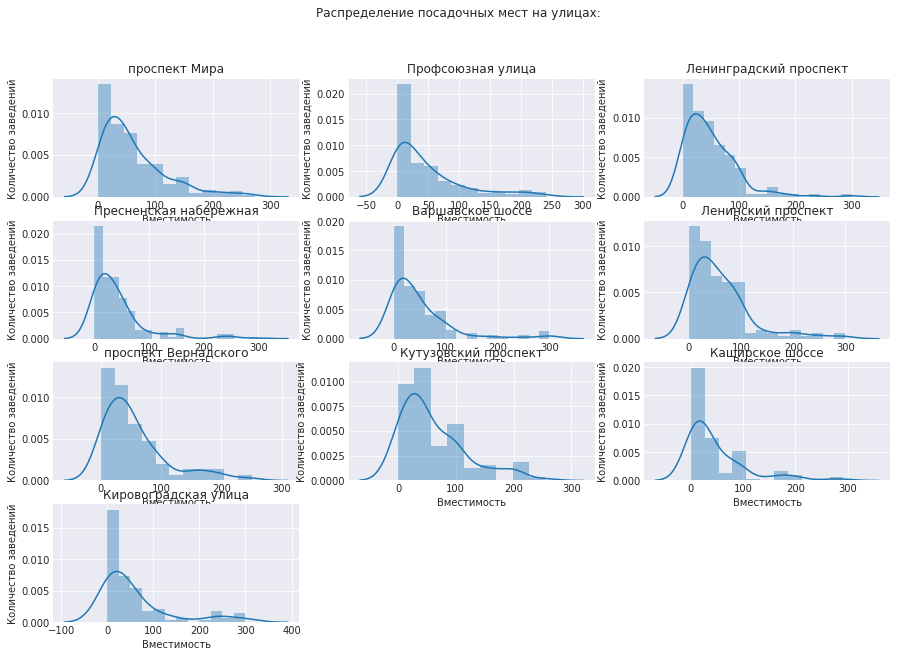

In [67]:
with plt.style.context('seaborn-darkgrid'):
  plt.figure(figsize=(15,10))
  for i, street in enumerate(street_top_10_list):
    num_cols = 3
    num_rows = 4
    plt.suptitle('Распределение посадочных мест на улицах:')
    sns.distplot(rest_data.query('street == @street')['number'], ax = plt.subplot(num_rows, num_cols, i + 1))
    plt.title(street)
    plt.xlabel('Вместимость')
    plt.ylabel('Количество заведений') 


Графики показывают, что почти все заведения на этих улицах имеют вместимость не более 100 человек. Основная часть - не больше 50.

## Выводы  <a id="conclusions"></a>

Итак, анализ данных о московских объектах общественного питания показал следующее:
* В Москве отдают предпочтение "быстрым" способам питания - на первом месте по количеству заведений стоят кафе, потом столовые, предприятия быстрого обслуживания. Рестораны с дорогими изысканными блюдами только на четвертом месте
* Самый популярный вид заведения среди сетевых объектов - предприятие быстрого обслуживания, среди уникальных - столовые
* Уникальных заведений в 4 раза больше по количеству, чем сетевых
* Сетевые заведения предпочитают экспансивную тактику: много точек с небольшим количеством посадочных мест
* Улицы, больше всего насыщенные объектами питания, проходят через несколько районов. Это главные радиусы Москвы. Исключение - Пресненский Вал, где находится Москва-Сити
* Средняя вместимость в заведениях, расположенных на этих улицах, не превышает 100 человек


## Рекомендации <a id="recommend"></a>

Для старта нового проекта - кафе, где обслуживанием будут заниматься роботы - лучше рассматривать в первую очередь Таганский район и Хамовники, где есть много улиц с одним объектом питания.

Тип заведения нужно выбирать среди наиболее популярных: кафе, предприятие быстрого обслуживания, ресторан. Можно произвести градацию уровня в зависимости от приближенности к центру.

Число посадочных мест не должно быть большим: в сетях оно не превышает в среднем 40-50.

## Презентация стартапа  <a id="presentation"></a>

Проведенный анализ позволил собрать данные для презентации потенциальным инвесторам.

Проект "Робоцып" обещает быть интересным!

Презентация: <https://drive.google.com/file/d/1kbQiaIVg5febf6OyTENw54cpfym6rHEO/view?usp=sharing>